# MNIST Generative Adversarial Network

In [4]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

import pickle
from tqdm import tqdm

In [5]:
# Importing data
dl_path = './MNIST'

# Run first time to download dataset
#mnist = fetch_openml('mnist_784', version=1, data_home=dl_path)

# After fetching and processing for the first time
#with open('./MNIST/mnist_processed.pkl', 'wb') as f:
#    pickle.dump(mnist, f)

# Pickled data for quick retrieval
with open('./MNIST/mnist_processed.pkl', 'rb') as f:
    mnist = pickle.load(f)

In [6]:
# Splitting into train/test data
X, y = mnist["data"], mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=10000, random_state=42, stratify=y)

X_train, X_test, y_train, y_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

# Undersampling training set to remove sampling bias
unique, counts = np.unique(y_train, return_counts=True)
min_samples = min(counts)

sample_ids = []
for u in unique :
    class_samples = y_train[y_train == u].index.to_numpy()

    random_indices = np.random.choice(len(class_samples), min_samples, replace=False)
    sample_ids.extend(class_samples[random_indices])

X_train, y_train = X_train.iloc[sample_ids], y_train.iloc[sample_ids]

# Convert data into PyTorch tensors
X_train_tensor = torch.tensor(X_train.values/255.0, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.astype(np.int64))
X_test_tensor = torch.tensor(X_test.values/255.0, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.astype(np.int64))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [202]:
# Define the Generator Network
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Tanh()  # Tanh activation produces output in the range [-1, 1]
        )

    def forward(self, z):
        return self.net(z)

# Define the Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Sigmoid activation produces a probability
        )

    def forward(self, x):
        return self.net(x)

# Hyperparameters
z_dim = 100
mnist_dim = 784
lr = 0.0002

# Initialize Networks
generator = Generator(z_dim, mnist_dim)
discriminator = Discriminator(mnist_dim)

# Send to GPU. Using M1 chip, comment out or replace with CUDA if not available
device = torch.device('mps:0')
dc_generator, dc_discriminator = generator.to(device), discriminator.to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr)


In [220]:
# Training Loop
num_epochs = 200
for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(tqdm(train_loader)):
        batch_size = real_images.size(0)
        
        # Labels
        real_images = real_images.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # Train Discriminator
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()
        
        # Train Generator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()
        
    print(f"Epoch {epoch}/{num_epochs}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

100%|██████████| 282/282 [00:04<00:00, 66.77it/s]


Epoch 0/200, d_loss: 0.1455850452184677, g_loss: 7.07483434677124


100%|██████████| 282/282 [00:03<00:00, 78.40it/s]


Epoch 1/200, d_loss: 0.1441992223262787, g_loss: 5.814548015594482


100%|██████████| 282/282 [00:03<00:00, 79.31it/s]


Epoch 2/200, d_loss: 0.06469857692718506, g_loss: 4.294915199279785


100%|██████████| 282/282 [00:03<00:00, 79.52it/s]


Epoch 3/200, d_loss: 0.16046085953712463, g_loss: 6.834439277648926


100%|██████████| 282/282 [00:03<00:00, 79.76it/s]


Epoch 4/200, d_loss: 0.11163249611854553, g_loss: 5.954436302185059


100%|██████████| 282/282 [00:03<00:00, 80.20it/s]


Epoch 5/200, d_loss: 0.34950512647628784, g_loss: 7.593278884887695


100%|██████████| 282/282 [00:03<00:00, 80.42it/s]


Epoch 6/200, d_loss: 0.06271108984947205, g_loss: 6.869611740112305


100%|██████████| 282/282 [00:03<00:00, 79.12it/s]


Epoch 7/200, d_loss: 0.06589990109205246, g_loss: 4.871110439300537


100%|██████████| 282/282 [00:03<00:00, 80.01it/s]


Epoch 8/200, d_loss: 0.06882909685373306, g_loss: 6.958292484283447


100%|██████████| 282/282 [00:03<00:00, 80.15it/s]


Epoch 9/200, d_loss: 0.17242109775543213, g_loss: 4.692274570465088


100%|██████████| 282/282 [00:03<00:00, 80.16it/s]


Epoch 10/200, d_loss: 0.10678127408027649, g_loss: 5.628222465515137


100%|██████████| 282/282 [00:03<00:00, 79.56it/s]


Epoch 11/200, d_loss: 0.035621415823698044, g_loss: 5.097190856933594


100%|██████████| 282/282 [00:03<00:00, 79.31it/s]


Epoch 12/200, d_loss: 0.20119470357894897, g_loss: 5.880695819854736


100%|██████████| 282/282 [00:03<00:00, 80.14it/s]


Epoch 13/200, d_loss: 0.3073391318321228, g_loss: 5.85446310043335


100%|██████████| 282/282 [00:03<00:00, 79.40it/s]


Epoch 14/200, d_loss: 0.13486887514591217, g_loss: 6.052479267120361


100%|██████████| 282/282 [00:03<00:00, 80.10it/s]


Epoch 15/200, d_loss: 0.05146828666329384, g_loss: 8.932162284851074


100%|██████████| 282/282 [00:03<00:00, 80.24it/s]


Epoch 16/200, d_loss: 0.16572058200836182, g_loss: 5.5703206062316895


100%|██████████| 282/282 [00:03<00:00, 79.80it/s]


Epoch 17/200, d_loss: 0.3115270733833313, g_loss: 6.615865707397461


100%|██████████| 282/282 [00:03<00:00, 79.95it/s]


Epoch 18/200, d_loss: 0.1398816704750061, g_loss: 5.820160865783691


100%|██████████| 282/282 [00:03<00:00, 79.91it/s]


Epoch 19/200, d_loss: 0.09546519815921783, g_loss: 5.745278835296631


100%|██████████| 282/282 [00:03<00:00, 79.60it/s]


Epoch 20/200, d_loss: 0.11379651725292206, g_loss: 5.331845760345459


100%|██████████| 282/282 [00:03<00:00, 80.19it/s]


Epoch 21/200, d_loss: 0.22992569208145142, g_loss: 5.743241786956787


100%|██████████| 282/282 [00:03<00:00, 77.73it/s]


Epoch 22/200, d_loss: 0.12888698279857635, g_loss: 5.843809127807617


100%|██████████| 282/282 [00:03<00:00, 80.29it/s]


Epoch 23/200, d_loss: 0.1821848452091217, g_loss: 5.6729416847229


100%|██████████| 282/282 [00:03<00:00, 80.12it/s]


Epoch 24/200, d_loss: 0.05002139136195183, g_loss: 8.076478958129883


100%|██████████| 282/282 [00:03<00:00, 79.57it/s]


Epoch 25/200, d_loss: 0.039287589490413666, g_loss: 7.102459907531738


100%|██████████| 282/282 [00:03<00:00, 80.01it/s]


Epoch 26/200, d_loss: 0.12850071489810944, g_loss: 7.384166717529297


100%|██████████| 282/282 [00:04<00:00, 68.41it/s]


Epoch 27/200, d_loss: 0.529559314250946, g_loss: 6.826197147369385


100%|██████████| 282/282 [00:04<00:00, 70.47it/s]


Epoch 28/200, d_loss: 0.05931895971298218, g_loss: 5.340080738067627


100%|██████████| 282/282 [00:04<00:00, 64.97it/s]


Epoch 29/200, d_loss: 0.10787683725357056, g_loss: 5.935236930847168


100%|██████████| 282/282 [00:04<00:00, 62.24it/s]


Epoch 30/200, d_loss: 0.3540113866329193, g_loss: 5.215001106262207


100%|██████████| 282/282 [00:04<00:00, 65.06it/s]


Epoch 31/200, d_loss: 0.05875589698553085, g_loss: 6.955493927001953


100%|██████████| 282/282 [00:04<00:00, 67.83it/s]


Epoch 32/200, d_loss: 0.0755607858300209, g_loss: 4.060608863830566


100%|██████████| 282/282 [00:04<00:00, 59.83it/s]


Epoch 33/200, d_loss: 0.25743556022644043, g_loss: 8.095056533813477


100%|██████████| 282/282 [00:04<00:00, 62.10it/s]


Epoch 34/200, d_loss: 0.17373278737068176, g_loss: 5.530724048614502


100%|██████████| 282/282 [00:04<00:00, 68.08it/s]


Epoch 35/200, d_loss: 0.281131774187088, g_loss: 5.598364353179932


100%|██████████| 282/282 [00:04<00:00, 69.70it/s]


Epoch 36/200, d_loss: 0.1853075623512268, g_loss: 6.062033176422119


100%|██████████| 282/282 [00:04<00:00, 65.25it/s]


Epoch 37/200, d_loss: 0.15778228640556335, g_loss: 6.3743977546691895


100%|██████████| 282/282 [00:04<00:00, 67.13it/s]


Epoch 38/200, d_loss: 0.09846733510494232, g_loss: 8.140223503112793


100%|██████████| 282/282 [00:04<00:00, 66.81it/s]


Epoch 39/200, d_loss: 0.1791565716266632, g_loss: 4.529105186462402


100%|██████████| 282/282 [00:04<00:00, 66.14it/s]


Epoch 40/200, d_loss: 0.22781512141227722, g_loss: 7.665584564208984


100%|██████████| 282/282 [00:04<00:00, 63.12it/s]


Epoch 41/200, d_loss: 0.3027048408985138, g_loss: 4.491418361663818


100%|██████████| 282/282 [00:04<00:00, 63.86it/s]


Epoch 42/200, d_loss: 0.2034379094839096, g_loss: 6.643473148345947


100%|██████████| 282/282 [00:04<00:00, 65.82it/s]


Epoch 43/200, d_loss: 0.19651508331298828, g_loss: 7.710269927978516


100%|██████████| 282/282 [00:04<00:00, 69.33it/s]


Epoch 44/200, d_loss: 0.33105015754699707, g_loss: 5.562547206878662


100%|██████████| 282/282 [00:04<00:00, 64.35it/s]


Epoch 45/200, d_loss: 0.11775524169206619, g_loss: 5.750012397766113


100%|██████████| 282/282 [00:04<00:00, 69.85it/s]


Epoch 46/200, d_loss: 0.04855024814605713, g_loss: 4.721158504486084


100%|██████████| 282/282 [00:04<00:00, 66.79it/s]


Epoch 47/200, d_loss: 0.03740362077951431, g_loss: 5.181541442871094


100%|██████████| 282/282 [00:04<00:00, 65.62it/s]


Epoch 48/200, d_loss: 0.2213973104953766, g_loss: 5.964052677154541


100%|██████████| 282/282 [00:04<00:00, 65.90it/s]


Epoch 49/200, d_loss: 0.26359814405441284, g_loss: 7.309883117675781


100%|██████████| 282/282 [00:04<00:00, 62.06it/s]


Epoch 50/200, d_loss: 0.166958287358284, g_loss: 6.541781902313232


100%|██████████| 282/282 [00:04<00:00, 66.74it/s]


Epoch 51/200, d_loss: 0.06681732088327408, g_loss: 5.209655284881592


100%|██████████| 282/282 [00:04<00:00, 64.46it/s]


Epoch 52/200, d_loss: 0.128850057721138, g_loss: 7.088200569152832


100%|██████████| 282/282 [00:04<00:00, 65.99it/s]


Epoch 53/200, d_loss: 0.32908058166503906, g_loss: 5.920884609222412


100%|██████████| 282/282 [00:03<00:00, 73.11it/s]


Epoch 54/200, d_loss: 0.19139395654201508, g_loss: 5.429594993591309


100%|██████████| 282/282 [00:04<00:00, 60.66it/s]


Epoch 55/200, d_loss: 0.20235933363437653, g_loss: 5.745171070098877


100%|██████████| 282/282 [00:04<00:00, 67.14it/s]


Epoch 56/200, d_loss: 0.06164601072669029, g_loss: 5.9395856857299805


100%|██████████| 282/282 [00:04<00:00, 62.73it/s]


Epoch 57/200, d_loss: 0.16200172901153564, g_loss: 6.0041608810424805


100%|██████████| 282/282 [00:04<00:00, 61.83it/s]


Epoch 58/200, d_loss: 0.16058988869190216, g_loss: 5.8599019050598145


100%|██████████| 282/282 [00:03<00:00, 72.22it/s]


Epoch 59/200, d_loss: 0.23172837495803833, g_loss: 6.983358383178711


100%|██████████| 282/282 [00:04<00:00, 65.63it/s]


Epoch 60/200, d_loss: 0.09849805384874344, g_loss: 6.0083136558532715


100%|██████████| 282/282 [00:04<00:00, 69.19it/s]


Epoch 61/200, d_loss: 0.07033273577690125, g_loss: 7.317411422729492


100%|██████████| 282/282 [00:03<00:00, 73.87it/s]


Epoch 62/200, d_loss: 0.1524525135755539, g_loss: 5.677652359008789


100%|██████████| 282/282 [00:04<00:00, 65.38it/s]


Epoch 63/200, d_loss: 0.10011202096939087, g_loss: 5.4724812507629395


100%|██████████| 282/282 [00:04<00:00, 66.54it/s]


Epoch 64/200, d_loss: 0.1727505326271057, g_loss: 6.5648369789123535


100%|██████████| 282/282 [00:04<00:00, 64.31it/s]


Epoch 65/200, d_loss: 0.19131574034690857, g_loss: 7.625472068786621


100%|██████████| 282/282 [00:04<00:00, 67.42it/s]


Epoch 66/200, d_loss: 0.2773292064666748, g_loss: 5.725645065307617


100%|██████████| 282/282 [00:04<00:00, 67.40it/s]


Epoch 67/200, d_loss: 0.1351117640733719, g_loss: 6.862752437591553


100%|██████████| 282/282 [00:04<00:00, 69.11it/s]


Epoch 68/200, d_loss: 0.22363895177841187, g_loss: 4.963475227355957


100%|██████████| 282/282 [00:04<00:00, 63.89it/s]


Epoch 69/200, d_loss: 0.11075501143932343, g_loss: 5.692351341247559


100%|██████████| 282/282 [00:04<00:00, 63.05it/s]


Epoch 70/200, d_loss: 0.18156865239143372, g_loss: 4.395303726196289


100%|██████████| 282/282 [00:03<00:00, 70.83it/s]


Epoch 71/200, d_loss: 0.11093450337648392, g_loss: 6.1931233406066895


100%|██████████| 282/282 [00:03<00:00, 71.64it/s]


Epoch 72/200, d_loss: 0.1325109899044037, g_loss: 4.4783782958984375


100%|██████████| 282/282 [00:03<00:00, 72.88it/s]


Epoch 73/200, d_loss: 0.13483178615570068, g_loss: 5.770766258239746


100%|██████████| 282/282 [00:03<00:00, 75.34it/s]


Epoch 74/200, d_loss: 0.0782415121793747, g_loss: 7.067508697509766


100%|██████████| 282/282 [00:03<00:00, 75.87it/s]


Epoch 75/200, d_loss: 0.0858200266957283, g_loss: 6.871500492095947


100%|██████████| 282/282 [00:03<00:00, 72.73it/s]


Epoch 76/200, d_loss: 0.09137248992919922, g_loss: 5.515335559844971


100%|██████████| 282/282 [00:04<00:00, 67.91it/s]


Epoch 77/200, d_loss: 0.37922385334968567, g_loss: 5.846914291381836


100%|██████████| 282/282 [00:03<00:00, 75.22it/s]


Epoch 78/200, d_loss: 0.2082170695066452, g_loss: 5.557982444763184


100%|██████████| 282/282 [00:03<00:00, 75.44it/s]


Epoch 79/200, d_loss: 0.21208089590072632, g_loss: 6.471452236175537


100%|██████████| 282/282 [00:03<00:00, 76.87it/s]


Epoch 80/200, d_loss: 0.20228427648544312, g_loss: 5.136533737182617


100%|██████████| 282/282 [00:03<00:00, 77.20it/s]


Epoch 81/200, d_loss: 0.12880052626132965, g_loss: 6.947011947631836


100%|██████████| 282/282 [00:03<00:00, 78.52it/s]


Epoch 82/200, d_loss: 0.180421844124794, g_loss: 4.030363082885742


100%|██████████| 282/282 [00:03<00:00, 75.91it/s]


Epoch 83/200, d_loss: 0.35854029655456543, g_loss: 4.206997394561768


100%|██████████| 282/282 [00:03<00:00, 77.48it/s]


Epoch 84/200, d_loss: 0.3907603621482849, g_loss: 7.675461292266846


100%|██████████| 282/282 [00:03<00:00, 76.50it/s]


Epoch 85/200, d_loss: 0.13814528286457062, g_loss: 6.57736349105835


100%|██████████| 282/282 [00:03<00:00, 78.15it/s]


Epoch 86/200, d_loss: 0.10493900626897812, g_loss: 6.171839237213135


100%|██████████| 282/282 [00:03<00:00, 78.50it/s]


Epoch 87/200, d_loss: 0.23341746628284454, g_loss: 8.609445571899414


100%|██████████| 282/282 [00:03<00:00, 77.01it/s]


Epoch 88/200, d_loss: 0.13852721452713013, g_loss: 5.724837303161621


100%|██████████| 282/282 [00:03<00:00, 75.83it/s]


Epoch 89/200, d_loss: 0.2898961901664734, g_loss: 5.348475933074951


100%|██████████| 282/282 [00:03<00:00, 71.92it/s]


Epoch 90/200, d_loss: 0.06981945782899857, g_loss: 5.368425369262695


100%|██████████| 282/282 [00:03<00:00, 74.84it/s]


Epoch 91/200, d_loss: 0.21277916431427002, g_loss: 5.75813627243042


100%|██████████| 282/282 [00:03<00:00, 73.61it/s]


Epoch 92/200, d_loss: 0.10114796459674835, g_loss: 5.616256237030029


100%|██████████| 282/282 [00:03<00:00, 77.66it/s]


Epoch 93/200, d_loss: 0.1430763304233551, g_loss: 5.480050086975098


100%|██████████| 282/282 [00:03<00:00, 76.77it/s]


Epoch 94/200, d_loss: 0.07933802902698517, g_loss: 7.224742889404297


100%|██████████| 282/282 [00:03<00:00, 77.81it/s]


Epoch 95/200, d_loss: 0.18337106704711914, g_loss: 6.3178887367248535


100%|██████████| 282/282 [00:03<00:00, 78.30it/s]


Epoch 96/200, d_loss: 0.2423597276210785, g_loss: 6.544548511505127


100%|██████████| 282/282 [00:03<00:00, 78.42it/s]


Epoch 97/200, d_loss: 0.12139540910720825, g_loss: 6.675082683563232


100%|██████████| 282/282 [00:03<00:00, 75.66it/s]


Epoch 98/200, d_loss: 0.22530536353588104, g_loss: 6.206982612609863


100%|██████████| 282/282 [00:03<00:00, 72.70it/s]


Epoch 99/200, d_loss: 0.38113030791282654, g_loss: 5.299874782562256


100%|██████████| 282/282 [00:03<00:00, 75.91it/s]


Epoch 100/200, d_loss: 0.2459910362958908, g_loss: 5.4415106773376465


100%|██████████| 282/282 [00:03<00:00, 78.21it/s]


Epoch 101/200, d_loss: 0.12459476292133331, g_loss: 4.98750114440918


100%|██████████| 282/282 [00:03<00:00, 75.03it/s]


Epoch 102/200, d_loss: 0.19739805161952972, g_loss: 5.435917377471924


100%|██████████| 282/282 [00:03<00:00, 75.47it/s]


Epoch 103/200, d_loss: 0.1061965823173523, g_loss: 7.664307117462158


100%|██████████| 282/282 [00:03<00:00, 77.83it/s]


Epoch 104/200, d_loss: 0.12005987763404846, g_loss: 4.666162490844727


100%|██████████| 282/282 [00:03<00:00, 78.74it/s]


Epoch 105/200, d_loss: 0.05339869111776352, g_loss: 5.54514217376709


100%|██████████| 282/282 [00:03<00:00, 78.63it/s]


Epoch 106/200, d_loss: 0.07654926925897598, g_loss: 7.387930870056152


100%|██████████| 282/282 [00:03<00:00, 77.72it/s]


Epoch 107/200, d_loss: 0.14925917983055115, g_loss: 6.761729717254639


100%|██████████| 282/282 [00:03<00:00, 77.89it/s]


Epoch 108/200, d_loss: 0.09757093340158463, g_loss: 5.835695266723633


100%|██████████| 282/282 [00:03<00:00, 77.62it/s]


Epoch 109/200, d_loss: 0.08480116724967957, g_loss: 6.3210015296936035


100%|██████████| 282/282 [00:03<00:00, 78.32it/s]


Epoch 110/200, d_loss: 0.2561079263687134, g_loss: 6.049230575561523


100%|██████████| 282/282 [00:03<00:00, 72.58it/s]


Epoch 111/200, d_loss: 0.09614070504903793, g_loss: 6.567122459411621


100%|██████████| 282/282 [00:03<00:00, 78.03it/s]


Epoch 112/200, d_loss: 0.030232299119234085, g_loss: 5.473979473114014


100%|██████████| 282/282 [00:03<00:00, 77.46it/s]


Epoch 113/200, d_loss: 0.20591336488723755, g_loss: 6.57974910736084


100%|██████████| 282/282 [00:03<00:00, 76.83it/s]


Epoch 114/200, d_loss: 0.3217224180698395, g_loss: 7.1878342628479


100%|██████████| 282/282 [00:03<00:00, 72.46it/s]


Epoch 115/200, d_loss: 0.07298984378576279, g_loss: 5.461594104766846


100%|██████████| 282/282 [00:03<00:00, 77.97it/s]


Epoch 116/200, d_loss: 0.056841760873794556, g_loss: 6.615336894989014


100%|██████████| 282/282 [00:03<00:00, 78.07it/s]


Epoch 117/200, d_loss: 0.14460650086402893, g_loss: 5.359910488128662


100%|██████████| 282/282 [00:03<00:00, 78.33it/s]


Epoch 118/200, d_loss: 0.06882589310407639, g_loss: 6.297783851623535


100%|██████████| 282/282 [00:03<00:00, 78.06it/s]


Epoch 119/200, d_loss: 0.25827381014823914, g_loss: 6.2430901527404785


100%|██████████| 282/282 [00:03<00:00, 76.70it/s]


Epoch 120/200, d_loss: 0.22532176971435547, g_loss: 6.6228718757629395


100%|██████████| 282/282 [00:03<00:00, 78.13it/s]


Epoch 121/200, d_loss: 0.15531647205352783, g_loss: 6.930963516235352


100%|██████████| 282/282 [00:03<00:00, 78.66it/s]


Epoch 122/200, d_loss: 0.10432925075292587, g_loss: 6.351822376251221


100%|██████████| 282/282 [00:03<00:00, 71.29it/s]


Epoch 123/200, d_loss: 0.18011534214019775, g_loss: 5.162294387817383


100%|██████████| 282/282 [00:04<00:00, 66.30it/s]


Epoch 124/200, d_loss: 0.08781422674655914, g_loss: 6.937004566192627


100%|██████████| 282/282 [00:03<00:00, 73.70it/s]


Epoch 125/200, d_loss: 0.1358911395072937, g_loss: 6.705478191375732


100%|██████████| 282/282 [00:03<00:00, 70.91it/s]


Epoch 126/200, d_loss: 0.15408359467983246, g_loss: 5.508585453033447


100%|██████████| 282/282 [00:03<00:00, 73.99it/s]


Epoch 127/200, d_loss: 0.06766588985919952, g_loss: 5.762339115142822


100%|██████████| 282/282 [00:04<00:00, 69.06it/s]


Epoch 128/200, d_loss: 0.09372466057538986, g_loss: 5.075628757476807


100%|██████████| 282/282 [00:04<00:00, 70.36it/s]


Epoch 129/200, d_loss: 0.19289159774780273, g_loss: 5.357420444488525


100%|██████████| 282/282 [00:03<00:00, 76.09it/s]


Epoch 130/200, d_loss: 0.17319297790527344, g_loss: 4.5591888427734375


100%|██████████| 282/282 [00:03<00:00, 74.23it/s]


Epoch 131/200, d_loss: 0.22007939219474792, g_loss: 7.920955657958984


100%|██████████| 282/282 [00:04<00:00, 68.30it/s]


Epoch 132/200, d_loss: 0.07176455855369568, g_loss: 5.7610673904418945


100%|██████████| 282/282 [00:03<00:00, 70.60it/s]


Epoch 133/200, d_loss: 0.16734221577644348, g_loss: 6.15776252746582


100%|██████████| 282/282 [00:03<00:00, 71.39it/s]


Epoch 134/200, d_loss: 0.14946947991847992, g_loss: 7.300488471984863


100%|██████████| 282/282 [00:04<00:00, 62.95it/s]


Epoch 135/200, d_loss: 0.07677339762449265, g_loss: 7.122195243835449


100%|██████████| 282/282 [00:03<00:00, 71.48it/s]


Epoch 136/200, d_loss: 0.08006999641656876, g_loss: 6.072595596313477


100%|██████████| 282/282 [00:04<00:00, 67.43it/s]


Epoch 137/200, d_loss: 0.20479734241962433, g_loss: 6.619282245635986


100%|██████████| 282/282 [00:04<00:00, 66.06it/s]


Epoch 138/200, d_loss: 0.24384954571723938, g_loss: 7.045616626739502


100%|██████████| 282/282 [00:04<00:00, 67.82it/s]


Epoch 139/200, d_loss: 0.11927618086338043, g_loss: 5.109714031219482


100%|██████████| 282/282 [00:03<00:00, 70.68it/s]


Epoch 140/200, d_loss: 0.3765963315963745, g_loss: 6.563004970550537


100%|██████████| 282/282 [00:04<00:00, 69.87it/s]


Epoch 141/200, d_loss: 0.1402677595615387, g_loss: 6.577771186828613


100%|██████████| 282/282 [00:03<00:00, 72.65it/s]


Epoch 142/200, d_loss: 0.10270429402589798, g_loss: 6.973174095153809


100%|██████████| 282/282 [00:03<00:00, 71.17it/s]


Epoch 143/200, d_loss: 0.19537878036499023, g_loss: 6.365166187286377


100%|██████████| 282/282 [00:03<00:00, 78.39it/s]


Epoch 144/200, d_loss: 0.057569194585084915, g_loss: 4.2219343185424805


100%|██████████| 282/282 [00:03<00:00, 77.50it/s]


Epoch 145/200, d_loss: 0.18977370858192444, g_loss: 5.812071800231934


100%|██████████| 282/282 [00:03<00:00, 77.27it/s]


Epoch 146/200, d_loss: 0.1747003197669983, g_loss: 5.184391975402832


100%|██████████| 282/282 [00:03<00:00, 78.21it/s]


Epoch 147/200, d_loss: 0.16637825965881348, g_loss: 4.466308116912842


100%|██████████| 282/282 [00:03<00:00, 78.28it/s]


Epoch 148/200, d_loss: 0.07895100116729736, g_loss: 6.609374523162842


100%|██████████| 282/282 [00:03<00:00, 77.98it/s]


Epoch 149/200, d_loss: 0.18827390670776367, g_loss: 6.1338090896606445


100%|██████████| 282/282 [00:03<00:00, 76.53it/s]


Epoch 150/200, d_loss: 0.11768527328968048, g_loss: 5.28960657119751


100%|██████████| 282/282 [00:03<00:00, 71.09it/s]


Epoch 151/200, d_loss: 0.0939788743853569, g_loss: 5.404860019683838


100%|██████████| 282/282 [00:03<00:00, 76.84it/s]


Epoch 152/200, d_loss: 0.09837358444929123, g_loss: 6.232309818267822


100%|██████████| 282/282 [00:03<00:00, 76.65it/s]


Epoch 153/200, d_loss: 0.3619009852409363, g_loss: 6.431575298309326


100%|██████████| 282/282 [00:03<00:00, 78.19it/s]


Epoch 154/200, d_loss: 0.08233945071697235, g_loss: 6.73426628112793


100%|██████████| 282/282 [00:03<00:00, 76.00it/s]


Epoch 155/200, d_loss: 0.13949522376060486, g_loss: 4.809214115142822


100%|██████████| 282/282 [00:03<00:00, 77.00it/s]


Epoch 156/200, d_loss: 0.38685521483421326, g_loss: 7.299559593200684


100%|██████████| 282/282 [00:03<00:00, 74.02it/s]


Epoch 157/200, d_loss: 0.1661481112241745, g_loss: 6.0523271560668945


100%|██████████| 282/282 [00:03<00:00, 78.31it/s]


Epoch 158/200, d_loss: 0.28565889596939087, g_loss: 4.831691265106201


100%|██████████| 282/282 [00:03<00:00, 77.35it/s]


Epoch 159/200, d_loss: 0.09345825016498566, g_loss: 4.7523651123046875


100%|██████████| 282/282 [00:04<00:00, 68.40it/s]


Epoch 160/200, d_loss: 0.09126953780651093, g_loss: 5.41692590713501


100%|██████████| 282/282 [00:04<00:00, 63.09it/s]


Epoch 161/200, d_loss: 0.10837645828723907, g_loss: 6.427781581878662


100%|██████████| 282/282 [00:04<00:00, 64.57it/s]


Epoch 162/200, d_loss: 0.11936674267053604, g_loss: 7.032163619995117


100%|██████████| 282/282 [00:04<00:00, 66.03it/s]


Epoch 163/200, d_loss: 0.21635966002941132, g_loss: 5.567038536071777


100%|██████████| 282/282 [00:03<00:00, 74.12it/s]


Epoch 164/200, d_loss: 0.17999514937400818, g_loss: 6.507325649261475


100%|██████████| 282/282 [00:03<00:00, 78.15it/s]


Epoch 165/200, d_loss: 0.18918228149414062, g_loss: 4.727237224578857


100%|██████████| 282/282 [00:03<00:00, 75.94it/s]


Epoch 166/200, d_loss: 0.20347942411899567, g_loss: 6.316674709320068


100%|██████████| 282/282 [00:03<00:00, 71.72it/s]


Epoch 167/200, d_loss: 0.15506145358085632, g_loss: 4.9571051597595215


100%|██████████| 282/282 [00:03<00:00, 72.69it/s]


Epoch 168/200, d_loss: 0.0968540757894516, g_loss: 5.69040584564209


100%|██████████| 282/282 [00:03<00:00, 77.51it/s]


Epoch 169/200, d_loss: 0.029995333403348923, g_loss: 5.245719909667969


100%|██████████| 282/282 [00:03<00:00, 78.64it/s]


Epoch 170/200, d_loss: 0.08698834478855133, g_loss: 6.484299182891846


100%|██████████| 282/282 [00:03<00:00, 78.61it/s]


Epoch 171/200, d_loss: 0.1250695288181305, g_loss: 5.757338523864746


100%|██████████| 282/282 [00:03<00:00, 78.57it/s]


Epoch 172/200, d_loss: 0.15698863565921783, g_loss: 6.639570713043213


100%|██████████| 282/282 [00:03<00:00, 77.52it/s]


Epoch 173/200, d_loss: 0.1158372089266777, g_loss: 5.267481327056885


100%|██████████| 282/282 [00:03<00:00, 73.46it/s]


Epoch 174/200, d_loss: 0.11191451549530029, g_loss: 6.727438926696777


100%|██████████| 282/282 [00:03<00:00, 75.33it/s]


Epoch 175/200, d_loss: 0.11679990589618683, g_loss: 6.061121940612793


100%|██████████| 282/282 [00:03<00:00, 73.11it/s]


Epoch 176/200, d_loss: 0.496673583984375, g_loss: 4.833118438720703


100%|██████████| 282/282 [00:04<00:00, 68.06it/s]


Epoch 177/200, d_loss: 0.21582578122615814, g_loss: 5.911139488220215


100%|██████████| 282/282 [00:03<00:00, 72.71it/s]


Epoch 178/200, d_loss: 0.2288246750831604, g_loss: 4.053781509399414


100%|██████████| 282/282 [00:03<00:00, 75.25it/s]


Epoch 179/200, d_loss: 0.04092147573828697, g_loss: 6.188947677612305


100%|██████████| 282/282 [00:03<00:00, 74.91it/s]


Epoch 180/200, d_loss: 0.1815745085477829, g_loss: 4.605339050292969


100%|██████████| 282/282 [00:04<00:00, 66.43it/s]


Epoch 181/200, d_loss: 0.14222553372383118, g_loss: 6.390617847442627


100%|██████████| 282/282 [00:03<00:00, 77.88it/s]


Epoch 182/200, d_loss: 0.07411360740661621, g_loss: 5.917108058929443


100%|██████████| 282/282 [00:03<00:00, 78.70it/s]


Epoch 183/200, d_loss: 0.23779036104679108, g_loss: 7.595695495605469


100%|██████████| 282/282 [00:03<00:00, 78.71it/s]


Epoch 184/200, d_loss: 0.0720176249742508, g_loss: 6.997048854827881


100%|██████████| 282/282 [00:03<00:00, 78.42it/s]


Epoch 185/200, d_loss: 0.26153671741485596, g_loss: 5.769843101501465


100%|██████████| 282/282 [00:03<00:00, 76.27it/s]


Epoch 186/200, d_loss: 0.11596769839525223, g_loss: 4.942704677581787


100%|██████████| 282/282 [00:03<00:00, 75.98it/s]


Epoch 187/200, d_loss: 0.08186063170433044, g_loss: 5.485113143920898


100%|██████████| 282/282 [00:03<00:00, 76.17it/s]


Epoch 188/200, d_loss: 0.13725578784942627, g_loss: 6.858788013458252


100%|██████████| 282/282 [00:03<00:00, 76.60it/s]


Epoch 189/200, d_loss: 0.26267004013061523, g_loss: 4.97459602355957


100%|██████████| 282/282 [00:03<00:00, 75.77it/s]


Epoch 190/200, d_loss: 0.15603622794151306, g_loss: 6.171695232391357


100%|██████████| 282/282 [00:03<00:00, 75.48it/s]


Epoch 191/200, d_loss: 0.13689370453357697, g_loss: 5.923281192779541


100%|██████████| 282/282 [00:03<00:00, 77.94it/s]


Epoch 192/200, d_loss: 0.18136006593704224, g_loss: 6.308772563934326


100%|██████████| 282/282 [00:03<00:00, 75.88it/s]


Epoch 193/200, d_loss: 0.1956425905227661, g_loss: 5.518055438995361


100%|██████████| 282/282 [00:03<00:00, 77.77it/s]


Epoch 194/200, d_loss: 0.05962865799665451, g_loss: 7.128769874572754


100%|██████████| 282/282 [00:03<00:00, 78.73it/s]


Epoch 195/200, d_loss: 0.14779670536518097, g_loss: 4.737586498260498


100%|██████████| 282/282 [00:03<00:00, 77.45it/s]


Epoch 196/200, d_loss: 0.13327014446258545, g_loss: 5.828100204467773


100%|██████████| 282/282 [00:03<00:00, 78.19it/s]


Epoch 197/200, d_loss: 0.29145437479019165, g_loss: 6.543573379516602


100%|██████████| 282/282 [00:03<00:00, 74.59it/s]


Epoch 198/200, d_loss: 0.2360019087791443, g_loss: 6.843725204467773


100%|██████████| 282/282 [00:03<00:00, 76.60it/s]

Epoch 199/200, d_loss: 0.16967543959617615, g_loss: 6.413506031036377


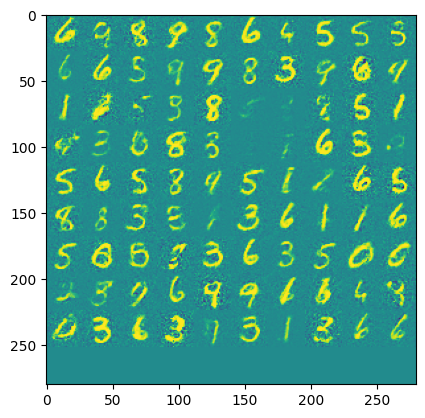

In [221]:
# Generating Samples
n, m = 10, 10
z = torch.randn(n*m, z_dim).to(device)
img_arr = np.zeros((n * 28, m * 28))
imgs = generator(z).cpu().detach().numpy()

for i, img in enumerate(imgs) :
    img_arr[28 * (i % (n-1)) : 28 * (i % (n-1) +1), (i // m) * 28 : 28 * (i // m + 1)] = img.reshape(28,28)

plt.imshow(img_arr)

## Deep Convolutional GANs

In [189]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 7, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 1, 3, 1, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(1, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Remove the third downsampling operation and adjust kernel size to 4x4
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Now, the output size should be 7x7, adjust the kernel size to get 1x1 output
            nn.Conv2d(512, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).squeeze()
    
# Hyperparameters
z_dim = 100
mnist_dim = 784
lr = 0.0002

# Initialize Networks
dc_generator = Generator(z_dim)
dc_discriminator = Discriminator()

# Send to GPU. Using M1 chip, comment out or replace with CUDA if not available
device = torch.device('mps:0')
dc_generator, dc_discriminator = dc_generator.to(device), dc_discriminator.to(device)
real_images, real_labels, fake_labels = real_images.to(device), real_labels.to(device), fake_labels.to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(dc_generator.parameters(), lr=lr)
optimizer_d = torch.optim.Adam(dc_discriminator.parameters(), lr=lr)

In [199]:
# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(tqdm(train_loader)):
        batch_size = real_images.size(0)
        
        # Reshape the real_images
        real_images = real_images.view(batch_size, 1, 28, 28).to(device)
        
        # Labels
        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.zeros(batch_size).to(device)
        
        # Train Discriminator
        outputs = dc_discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        
        z = torch.randn(batch_size, z_dim, 1, 1).to(device)  # Adjust this for ConvTranspose2d
        fake_images = dc_generator(z)
        outputs = dc_discriminator(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()
        
        # Train Generator
        z = torch.randn(batch_size, z_dim, 1, 1).to(device)  # Adjust this for ConvTranspose2d
        fake_images = dc_generator(z)
        outputs = dc_discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()
        
    print(f"Epoch {epoch}/{num_epochs}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")


100%|██████████| 282/282 [01:39<00:00,  2.83it/s]


Epoch 0/50, d_loss: 0.0003124132927041501, g_loss: 11.233099937438965


100%|██████████| 282/282 [01:38<00:00,  2.87it/s]


Epoch 1/50, d_loss: 1.409468131896574e-05, g_loss: 11.818198204040527


100%|██████████| 282/282 [01:40<00:00,  2.82it/s]


Epoch 2/50, d_loss: 0.00010747455962700769, g_loss: 12.282317161560059


100%|██████████| 282/282 [01:43<00:00,  2.71it/s]


Epoch 3/50, d_loss: 1.5332139810197987e-05, g_loss: 13.520247459411621


 19%|█▉        | 53/282 [00:20<01:29,  2.56it/s]


KeyboardInterrupt: 

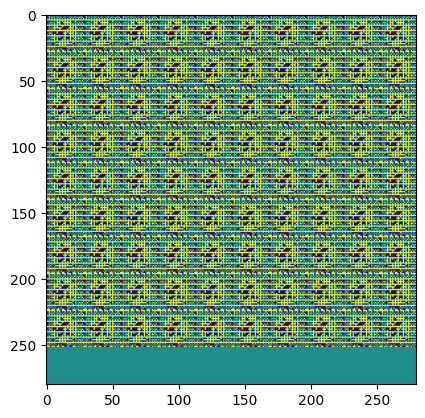

In [201]:
# Generating Samples
n, m = 10, 10
z = torch.randn(n*m, z_dim, 1, 1).to(device)
img_arr = np.zeros((n * 28, m * 28))
imgs = dc_generator(z).cpu().detach().numpy()

for i, img in enumerate(imgs) :
    img_arr[28 * (i % (n-1)) : 28 * (i % (n-1) +1), (i // m) * 28 : 28 * (i // m + 1)] = img.reshape(28,28)

plt.imshow(img_arr)

In [171]:
torch.device("mps")

device(type='mps')

In [186]:
real_images

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [188]:
dc_discriminator(real_images)

tensor([0.4862, 0.4947, 0.4647, 0.5034, 0.4378, 0.3547, 0.3813, 0.3891, 0.4417,
        0.4368, 0.5481, 0.4913, 0.4761, 0.4267, 0.4282, 0.4233, 0.5465, 0.4257,
        0.4579, 0.4119, 0.4617, 0.4642, 0.3987, 0.3616, 0.4501, 0.5105, 0.5652,
        0.4456, 0.3794, 0.4647, 0.5049, 0.3311], grad_fn=<SqueezeBackward0>)